Wednesday, June 21, 2023

My walkthrough of the notebook ...

[Chapter-2-Machine-Translation.ipynb](https://github.com/CRCTransformers/deepdive-book/blob/main/Chapter-2-Machine-Translation.ipynb)



### Machine Translation Comparison: Attention vs Transformer

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

Why do I always have so many issues with spacy??

!python -m spacy download fr  ... this NEVER works!

In [2]:
import spacy
import spacy.cli

In [3]:
spacyDownload = True
if spacyDownload:
    spacy.cli.download("en_core_web_sm")
    spacy.cli.download("fr_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.2 MB/s eta 0:00:00


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 1.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [4]:
# !pip install ecco
# !pip install torchtext
# !pip install wget

# this would not work ... had to run outside of this container ...sigh
# %%capture
# !wget https://download.pytorch.org/tutorial/data.zip && unzip data.zip && rm data.zip

In [5]:
from io import open
import unicodedata
import string
import re
import random
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator
from collections import Counter 

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import ecco
     

In [6]:
MAX_SENTENCE_LENGTH = 20
FILTER_TO_BASIC_PREFIXES = False
SAVE_DIR = os.path.join(".", "models")

ENCODER_EMBEDDING_DIM = 256
ENCODER_HIDDEN_SIZE = 256
DECODER_EMBEDDING_DIM = 256
DECODER_HIDDEN_SIZE = 256

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    !nvidia-smi
else:
    device = torch.device("cpu")
device

Wed Jun 21 21:25:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P0    N/A /  70W |    411MiB /  2048MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 24%   

device(type='cuda')

In [8]:
with open('data/eng-fra.txt', encoding="utf-8") as f:
    lines = f.read().strip().split("\n")

In [9]:
print(f"{len(lines):,} English-French phrase pairs.\n")
print("~~~~~ Examples: ~~~~~")
for example in random.choices(lines, k=5):
    pair = example.split('\t')
    print(f"English:  {pair[0]}")
    print(f"French:   {pair[1]}")
    print()

135,842 English-French phrase pairs.

~~~~~ Examples: ~~~~~
English:  They are the ones who want to go.
French:   Ce sont ceux qui veulent partir.

English:  You have no cause for anger.
French:   Tu n'as pas de raison de t'énerver.

English:  After we walked for a while, we arrived at the lake.
French:   Après avoir marché un moment, nous arrivâmes au lac.

English:  They were not listening to music.
French:   Elles n'écoutaient pas de musique.

English:  That's all you can do.
French:   C'est tout ce que tu peux faire.



In [10]:
def unicodeToAscii(s):
    return ''.join(
      c for c in unicodedata.normalize('NFD', s) 
      if unicodedata.category(c) != 'Mn'
    )

In [11]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z.!?]+", " ", s)
    return s

In [12]:
def filterPair(p, max_length, prefixes):
    good_length = (len(p[0].split(' ')) < max_length) and (len(p[1].split(' ')) < max_length)
    if len(prefixes) == 0:
        return good_length
    else:
        return good_length and p[0].startswith(prefixes)

In [13]:
def filterPairs(pairs, max_length, prefixes=()):
    return [pair for pair in pairs if filterPair(pair, max_length, prefixes)]

In [14]:
def prepareData(lines, filter=False, reverse=False, max_length=10, prefixes=()):
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    print(f"Given {len(pairs):,} sentence pairs.")

    if filter:
        pairs = filterPairs(pairs, max_length=max_length, prefixes=prefixes)
        print(f"After filtering, {len(pairs):,} remain.")

    return pairs

In [15]:
basic_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ",
    'are you', 'am i ', 
    'were you', 'was i ', 
    'where are', 'where is',
    'what is', 'what are'
)

In [16]:
pairs = prepareData(lines, 
                    filter=True, 
                    max_length=MAX_SENTENCE_LENGTH, 
                    prefixes=basic_prefixes if FILTER_TO_BASIC_PREFIXES else ())

Given 135,842 sentence pairs.
After filtering, 135,284 remain.


The notebook from the authors repo shows 15, 593 remaining. Why do we get 135,284?

Let's try to explore this, shall we ... 

In [17]:
pairs2 = [[normalizeString(s) for s in l.split('\t')] for l in lines]

In [18]:
filteredPairs = filterPairs(pairs2, max_length=20, prefixes=basic_prefixes)
len(filteredPairs)

15593

In [19]:
filteredPairs = filterPairs(pairs2, max_length=20, prefixes=())
len(filteredPairs)

135284

In [20]:
pairs2[:10]

[['go.', 'va !'],
 ['run!', 'cours !'],
 ['run!', 'courez !'],
 ['wow!', 'ca alors !'],
 ['fire!', 'au feu !'],
 ['help!', 'a l aide !'],
 ['jump.', 'saute.'],
 ['stop!', 'ca suffit !'],
 ['stop!', 'stop !'],
 ['stop!', 'arrete toi !']]

### Prepare the data for modelling

In [21]:
# fr_tokenizer = get_tokenizer('spacy', language='fr')
# en_tokenizer = get_tokenizer('spacy', language='en')
fr_tokenizer = get_tokenizer('spacy', language='fr_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [22]:
SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>']

In [23]:
en_list = []
fr_list = []
en_counter = Counter()
fr_counter = Counter()
en_lengths = []
fr_lengths = []

In [24]:
for en, fr in pairs:
    en_toks = en_tokenizer(en)
    fr_toks = fr_tokenizer(fr)
    en_list += [en_toks]
    fr_list += [fr_toks]
    en_counter.update(en_toks)
    fr_counter.update(fr_toks)
    en_lengths.append(len(en_toks))
    fr_lengths.append(len(fr_toks))

In [25]:
en_list[:10]

[['go', '.'],
 ['run', '!'],
 ['run', '!'],
 ['wow', '!'],
 ['fire', '!'],
 ['help', '!'],
 ['jump', '.'],
 ['stop', '!'],
 ['stop', '!'],
 ['stop', '!']]

In [27]:
en_vocab = build_vocab_from_iterator(en_list, specials=SPECIALS)
fr_vocab = build_vocab_from_iterator(fr_list, specials=SPECIALS)

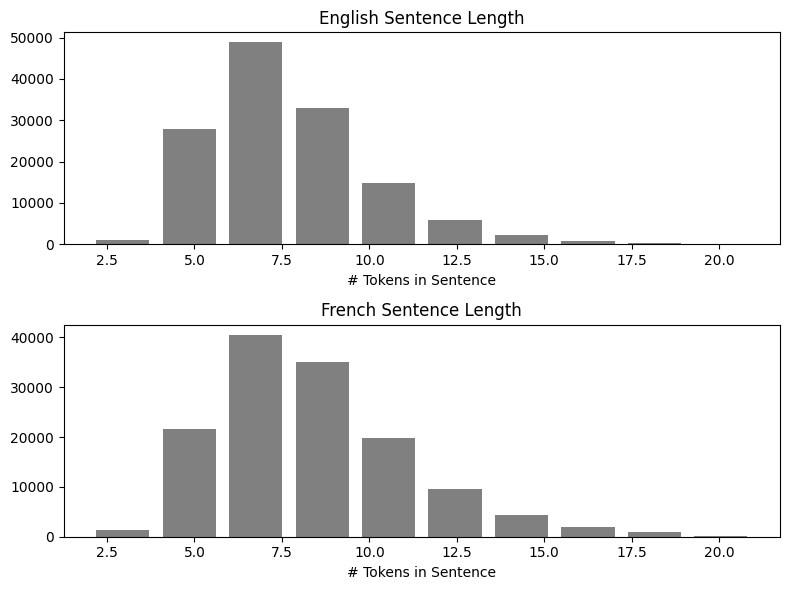

In [28]:
fig = plt.figure(figsize=(8, 6))
ax0 = fig.add_subplot(211)
ax0.hist(en_lengths, rwidth=0.8, color='gray')
ax0.set_title("English Sentence Length")
ax0.set_xlabel("# Tokens in Sentence")

ax1 = fig.add_subplot(212)
ax1.hist(fr_lengths, rwidth=0.8, color='gray')
ax1.set_title("French Sentence Length")
ax1.set_xlabel("# Tokens in Sentence")

plt.tight_layout()
plt.show()

In [ ]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")
